In [1]:
import os
import pickle
from itertools import combinations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler
from matplotlib.cm import ScalarMappable
import seaborn as sns
import tensorflow as tf
from scipy.stats import pearsonr, gaussian_kde
from sklearn.decomposition import PCA
from sgcc_model12 import *

In [2]:
X = tf.convert_to_tensor([0.02,0.04,0.08,0.1,0.12,0.16,0.2,0.24,0.28,0.32], dtype = tf.float32)

In [3]:
v1_xs_file = f"v1_ori_phase_condition_pcascores.pkl"
v1_scores = pd.read_pickle(os.path.join('c:\\',*os.getcwd().split('\\')[1:-1], v1_xs_file))
#v1_scores = pd.read_pickle(os.path.join('/',*os.getcwd().split('/')[:-1], v1_xs_file))
v1_scores_condition_averaged = np.array([np.array(x) for x in v1_scores.scores.values]).mean(0)

In [4]:
Y_true = v1_scores_condition_averaged[:2,:,:].transpose(0,2,1)

In [5]:
param_bounds = {
    "fts": [20, 200],
    "t": [40, 100],
    "ats": [-3, 0],
    "a": [0.1, 4],
    "d": [10, 40],
    "inh_d": [0, 40],
    "inh_w": [0, 3],
}

In [6]:
sgcc = SGCCircuit(param_bounds)

In [7]:
sgcc.initialize_random_parameters(n_v1=2, n_lgn=3, n_sample=1000)

In [8]:
optimizer = Optimize(sgcc, epochs=10000, loss_threshold=0.11)

Optimizer initialized with <keras.optimizers.optimizer_v2.adam.Adam object at 0x000002726CF3D4F0>


In [9]:
loss_decay = optimizer.fit(X, Y_true)

Training step = 0, N_exploration_samples = 1000,
min_loss = 0.4329451620578766
med_loss = 7.600973129272461
max_loss = 69.83982849121094

Training step = 100, N_exploration_samples = 1000,
min_loss = 0.3227928876876831
med_loss = 5.653071403503418
max_loss = 62.90795135498047

Training step = 200, N_exploration_samples = 1000,
min_loss = 0.2631130516529083
med_loss = 4.360342502593994
max_loss = 56.247650146484375

Training step = 300, N_exploration_samples = 1000,
min_loss = 0.2231258749961853
med_loss = 3.3925600051879883
max_loss = 49.92690658569336

Training step = 400, N_exploration_samples = 1000,
min_loss = 0.1944810003042221
med_loss = 2.6734769344329834
max_loss = 44.00198745727539

Training step = 500, N_exploration_samples = 1000,
min_loss = 0.18009160459041595
med_loss = 2.1003754138946533
max_loss = 38.51641082763672

Training step = 600, N_exploration_samples = 1000,
min_loss = 0.17209000885486603
med_loss = 1.7093794345855713
max_loss = 33.498756408691406

Training step 

In [ ]:
# optimizer.save_state('sgcc_mop_2_9_26', write=True)

In [11]:
res = optimizer.outputs
param_history = res['param_history']

In [12]:
loss_decay = res['loss_decay']
last_epoch = loss_decay[-1]
best = np.where(last_epoch == last_epoch.min())[0][0]
print(f"Index of best parameters: {best}, loss = {last_epoch[best]}")

Index of best parameters: 267, loss = 0.10986328125


In [13]:
def minmax_norm(array, lower, upper):
    if (array.max() - array.min()) != 0:
        norm = (array - array.min()) / (array.max() - array.min())
        return lower + (norm * (upper-lower))
    else:
        return array

Text(0.5, 1.0, 'Loss decay over training epochs')

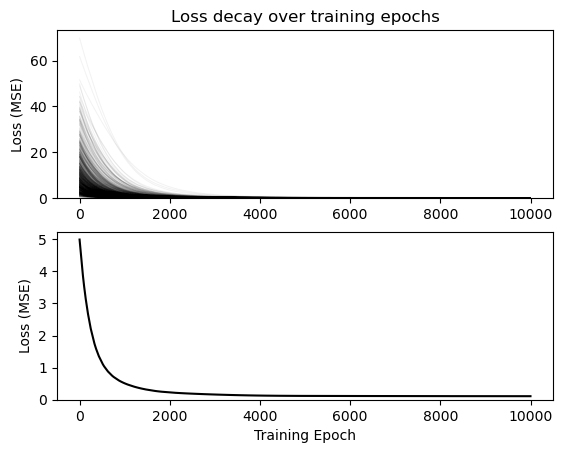

In [14]:
fig, ax = plt.subplots(2)

for i, decay in enumerate(loss_decay.T):
    ax[0].plot(decay, alpha = 0.05, color = 'black', linewidth = 0.75)
#ax[0].plot(loss_decay[:,best], alpha = 1, color = 'black')
ax[1].set_xlabel("Training Epoch")
ax[0].set_ylabel("Loss (MSE)")
ax[0].set_ylim(0,)

ax[1].set_ylabel("Loss (MSE)")
ax[1].plot(loss_decay[:,best], alpha = 1, color = 'black')
ax[1].set_ylim(0.)
ax[0].set_title("Loss decay over training epochs")

Text(0.525, 0.95, 'Distribution of V1 parameters post-optimization')

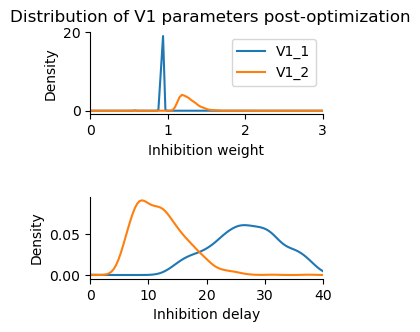

In [15]:
fig, ax = plt.subplots(2,1, figsize = (3,2*(8/5)))

for i in range(2):
    i_ = np.abs(i-1)
    for u in range(2):
        x = np.linspace(
            list(param_bounds.values())[-1-i][0],
            list(param_bounds.values())[-1-i][1],
            100
        )
        data = param_history['V1_params'][:,-1,u,0,i_,0,0]
        kde = gaussian_kde(data)
        y = kde(x)

        ax[i].plot(x,y, label = f'V1_{u+1}')
        ax[i].set_xlim(
            list(param_bounds.values())[-1-i][0],
            list(param_bounds.values())[-1-i][1]
        )
        ax[i].set_ylabel("Density")
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)

ax[0].set_xlabel('Inhibition weight')
ax[1].set_xlabel('Inhibition delay')
ax[0].legend()
fig.subplots_adjust(hspace=1)
plt.suptitle("Distribution of V1 parameters post-optimization", x = 0.525, y = 0.95)

Text(0.525, 0.95, 'Distribution of dLGN parameters post-optimization')

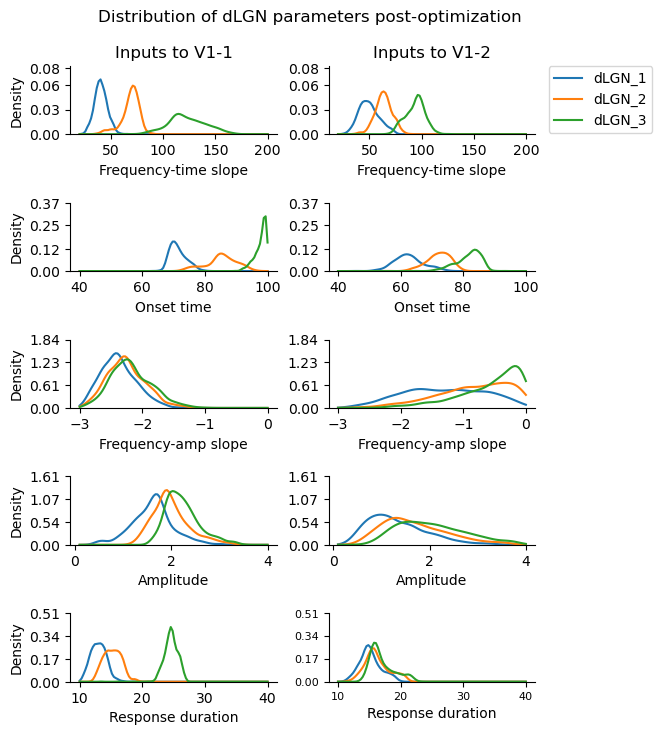

In [16]:
fig, ax = plt.subplots(5,2, figsize = (6,8))

param_labels = [
    'Frequency-time slope',
    'Onset time',
    'Frequency-amp slope',
    'Amplitude',
    'Response duration'
]

neuron_labels = [f'dLGN_{i+1}' for i in range(3)]


for row in range(5):
    ymax = []
    for i in range(3):
        for u in range(2):
            data = param_history['dLGN_params'][:,-1,u,i,row,0,0]
            x = np.linspace(
                list(param_bounds.values())[:5][row][0],
                list(param_bounds.values())[:5][row][1], 
                100
            )
            kde = gaussian_kde(data)
            y = kde(x)

            ymax.append(y.max())
            
            ax[row, u].plot(x, y, label = neuron_labels[i])
            ax[row, u].set_xlabel(param_labels[row])

    ax[row, 0].set_ylabel("Density")
    for u in range(2):
        ax[row, u].set_ylim(0, np.max(ymax)+np.max(ymax)*0.25)
        ax[row, u].set_yticks(np.linspace(0, np.max(ymax)+np.max(ymax)*0.25, 4).round(2))
        ax[row, u].spines['top'].set_visible(False)
        ax[row, u].spines['right'].set_visible(False)

fig.subplots_adjust(hspace = 1, wspace=0.25)
plt.tick_params(labelsize = 8)
ax[0,1].legend(fontsize = 10, bbox_to_anchor = (1.6,1.1))
ax[0,0].set_title("Inputs to V1-1")
ax[0,1].set_title("Inputs to V1-2")
plt.suptitle("Distribution of dLGN parameters post-optimization", x = 0.525, y = 0.95)

In [17]:
## Merge all parameters into a single structure, dim = (exploration samples x epochs, parameters)
## The parameters are ordered as the following:
## dLGN0-1x5, dLGN0-2x5, dLGN0-3x5
## dLGN1-1x5, dLGN1-2x5, dLGN1-3x5
## V1-0x2, V1-1x2
## Where the 5 dLGN parameters are: 
## 1) Frequency-time slope, 2) onset time, 3) Amplitude-time slope
## 4) Amplitude, Response Duration
## And the 2 V1 parameters are:
## 1) Inhibition delay, 2) Inhibition weight 

r1 = res['param_history']['dLGN_params'].squeeze()[:]
r2 = res['param_history']['V1_params'].squeeze()[:]

n_samples, n_epochs = r1.shape[:2]
n_params = np.prod(r1.shape[2:]) + np.prod(r2.shape[2:])

r1 = r1.reshape(r1.shape[0] * r1.shape[1], np.prod(r1.shape[2:]))
r2 = r2.reshape(r2.shape[0] *  r2.shape[1], np.prod(r2.shape[2:]))

res_merged = np.concatenate([r1, r2], axis = 1)

In [18]:
res_unflat = res_merged.reshape(n_samples, n_epochs, n_params)

In [19]:
def minmax_norm(array, lower, upper):
    if (array.max() - array.min()) != 0:
        norm = (array - array.min()) / (array.max() - array.min())
        return lower + (norm * (upper-lower))
    else:
        return array

Text(0.54, 0.98, 'Frequency-time slopes of dLGN inputs into V1_1')

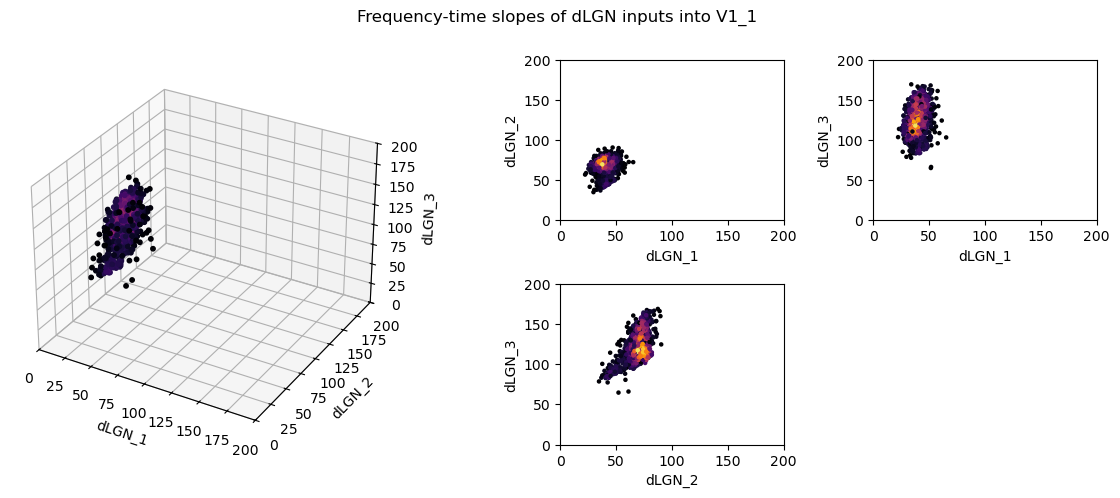

In [20]:
fig = plt.figure(figsize=(15, 5))
grid = plt.GridSpec(2, 4, hspace=0.4, wspace=0.4)
ax = [
    fig.add_subplot(grid[:2,:2], projection='3d'),
    fig.add_subplot(grid[0,2]),
    fig.add_subplot(grid[0,3]),
    fig.add_subplot(grid[1,2])
]

data = np.array([
    res_unflat[:,-1, 0],
    res_unflat[:,-1, 5],
    res_unflat[:,-1, 10],
])

kde = gaussian_kde(data)
density = kde(data)
cmap = plt.get_cmap('inferno')(minmax_norm(density, 0, 1))

ax[0].scatter3D(
    data[0],
    data[1],
    data[2],
    color = cmap,
    s = 10,
    alpha = 1
)

ax[0].set_xlim(0, 200)
ax[0].set_ylim(0, 200)
ax[0].set_zlim(0, 200)

labels = [
    "dLGN_1",
    "dLGN_2",
    "dLGN_3"
]

ax[0].set_xlabel(labels[0])
ax[0].set_ylabel(labels[1])
ax[0].set_zlabel(labels[2])

combos = combinations(np.arange(3), 2)

for i, combo in enumerate(combos):
    x_i, y_i = combo

    x = data[x_i]
    y = data[y_i]

    xlabel = labels[x_i]
    ylabel = labels[y_i]

    ax[i+1].scatter(x, y, color = cmap, s = 5, alpha = 1)
    ax[i+1].set_xlabel(xlabel)
    ax[i+1].set_ylabel(ylabel)
    ax[i+1].set_xlim(0, 200)
    ax[i+1].set_ylim(0, 200)

plt.suptitle("Frequency-time slopes of dLGN inputs into V1_1", x = 0.54)

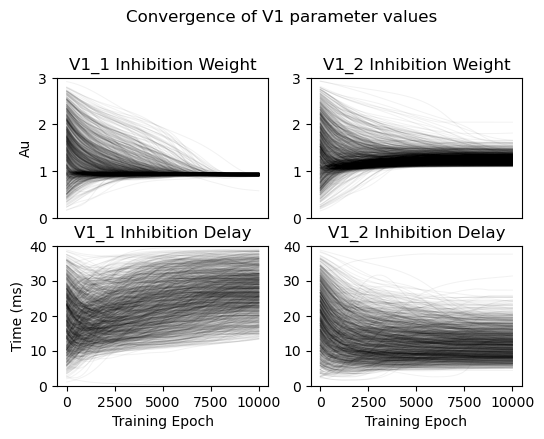

In [24]:
## inhibition weight::inhibition delay

fig, ax = plt.subplots(2,2, figsize = (6,4))

inh_w = 1
v1_n = 0 
ax[0,0].plot(
    param_history['V1_params'][:,:,v1_n,0,inh_w,0,0].T,
    linewidth=0.75,
    alpha=0.05,
    color = 'black'
)

# 
v1_n = 1
ax[0,1].plot(
    param_history['V1_params'][:,:,v1_n,0,inh_w,0,0].T,
    linewidth=0.75,
    alpha=0.05,
    color = 'black'
)

# a0
inh_d = 0
v1_n = 0
ax[1,0].plot(
    param_history['V1_params'][:,:,v1_n,0,inh_d,0,0].T,
    linewidth=0.75,
    alpha=0.05,
    color = 'black'
)

# a1
v1_n = 1
ax[1,1].plot(
    param_history['V1_params'][:,:,v1_n,0,inh_d,0,0].T,
    linewidth=0.75,
    alpha=0.05,
    color = 'black'
)

ax[0,0].set_ylim(0,3)
ax[0,0].set_title("V1_1 Inhibition Weight")
ax[0,0].set_xticks([])
ax[0,0].set_ylabel("Au")

ax[0,1].set_ylim(0,3)
ax[0,1].set_title("V1_2 Inhibition Weight")
ax[0,1].set_xticks([])

ax[1,0].set_ylim(0,40)
ax[1,0].set_title("V1_1 Inhibition Delay")
ax[1,0].set_ylabel("Time (ms)")
ax[1,0].set_xlabel("Training Epoch")
# ax[1,0].set_xticks(np.arange(0,20500,500))
# ax[1,0].set_xticklabels(np.arange(0,20500,500), rotation = 90)

ax[1,1].set_ylim(0,40)
ax[1,1].set_title("V1_2 Inhibition Delay")
ax[1,1].set_xlabel("Training Epoch")
# ax[1,1].set_xticks(np.arange(0,20500,500))
# ax[1,1].set_xticklabels(np.arange(0,20500,500), rotation = 90)
plt.suptitle("Convergence of V1 parameter values", y = 1.05)
plt.show()

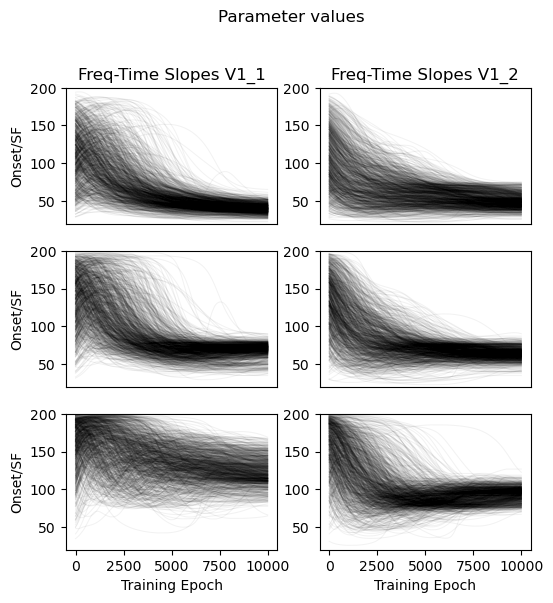

In [25]:
fig, ax = plt.subplots(3,2, figsize = (6,6))
norm = plt.Normalize(0, 1)

param = 0

for col in range(2):
    for row in range(3):
        data = param_history['dLGN_params'][:,:,col,row,param,0,0].T
        ax[row,col].plot(
        param_history['dLGN_params'][:,:,col,row,param,0,0].T,
            linewidth=0.75,
            alpha=0.05,
            color='black'
        )

for i in range(2):
    ax[0,i].set_title(f"Freq-Time Slopes V1_{i+1}")
for i in range(3):
    ax[i,0].set_ylabel("Onset/SF")
for row in range(2):
    for col in range(2):
        ax[row,col].set_xticks([])
for row in range(3):
    for col in range(2):
        ax[row,col].set_ylim(20,200)
for i in range(2):
    ax[2,i].set_xlabel("Training Epoch")
    # ax[2,i].set_xticks(np.arange(0,5500,500))
    # ax[2,i].set_xticklabels(np.arange(0,5500,500), rotation = 90)
plt.suptitle("Parameter values", y = 1.01)
plt.show()

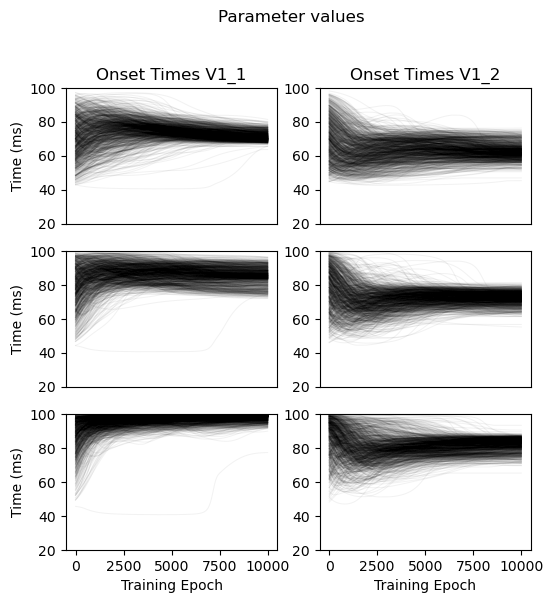

In [26]:
fig, ax = plt.subplots(3,2, figsize = (6,6))
norm = plt.Normalize(0, 1)

param = 1

for col in range(2):
    for row in range(3):
        data = param_history['dLGN_params'][:,:,col,row,param,0,0].T
        ax[row,col].plot(
        param_history['dLGN_params'][:,:,col,row,param,0,0].T,
            linewidth=0.75,
            alpha=0.05,
            color='black'
        )

for i in range(2):
    ax[0,i].set_title(f"Onset Times V1_{i+1}")
for i in range(3):
    ax[i,0].set_ylabel("Time (ms)")
for row in range(2):
    for col in range(2):
        ax[row,col].set_xticks([])
for row in range(3):
    for col in range(2):
        ax[row,col].set_ylim(20,100)
for i in range(2):
    ax[2,i].set_xlabel("Training Epoch")
    # ax[2,i].set_xticks(np.arange(0,5500,500))
    # ax[2,i].set_xticklabels(np.arange(0,5500,500), rotation = 90)
plt.suptitle("Parameter values", y = 1.01)
plt.show()

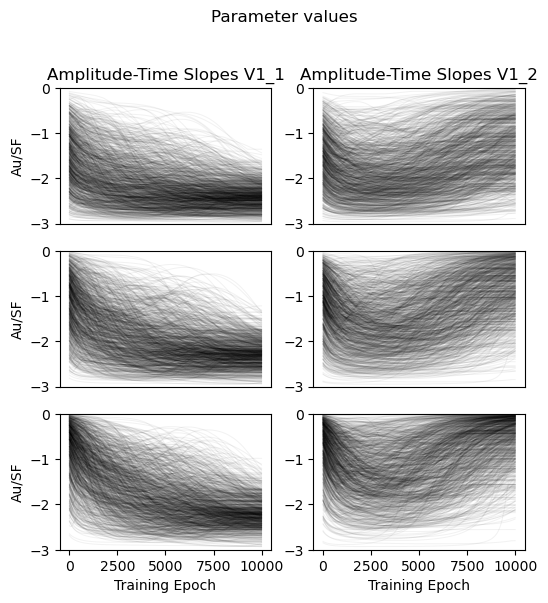

In [27]:
fig, ax = plt.subplots(3,2, figsize = (6,6))
norm = plt.Normalize(0, 1)

param = 2

for col in range(2):
    for row in range(3):
        data = param_history['dLGN_params'][:,:,col,row,param,0,0].T
        ax[row,col].plot(
        param_history['dLGN_params'][:,:,col,row,param,0,0].T,
            linewidth=0.75,
            alpha=0.05,
            color='black'
        )

for i in range(2):
    ax[0,i].set_title(f"Amplitude-Time Slopes V1_{i+1}")
for i in range(3):
    ax[i,0].set_ylabel("Au/SF")
for row in range(2):
    for col in range(2):
        ax[row,col].set_xticks([])
for row in range(3):
    for col in range(2):
        ax[row,col].set_ylim(-3,0)
for i in range(2):
    ax[2,i].set_xlabel("Training Epoch")
    # ax[2,i].set_xticks(np.arange(0,5500,500))
    # ax[2,i].set_xticklabels(np.arange(0,5500,500), rotation = 90)
plt.suptitle("Parameter values", y = 1.01)
plt.show()

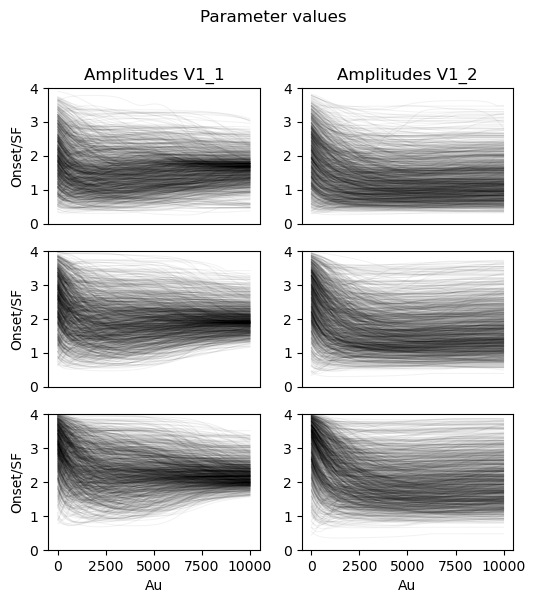

In [28]:
fig, ax = plt.subplots(3,2, figsize = (6,6))
norm = plt.Normalize(0, 1)

param = 3

for col in range(2):
    for row in range(3):
        data = param_history['dLGN_params'][:,:,col,row,param,0,0].T
        ax[row,col].plot(
        param_history['dLGN_params'][:,:,col,row,param,0,0].T,
            linewidth=0.75,
            alpha=0.05,
            color='black'
        )

for i in range(2):
    ax[0,i].set_title(f"Amplitudes V1_{i+1}")
for i in range(3):
    ax[i,0].set_ylabel("Onset/SF")
for row in range(2):
    for col in range(2):
        ax[row,col].set_xticks([])
for row in range(3):
    for col in range(2):
        ax[row,col].set_ylim(0,4)
for i in range(2):
    ax[2,i].set_xlabel("Au")
    # ax[2,i].set_xticks(np.arange(0,5500,500))
    # ax[2,i].set_xticklabels(np.arange(0,5500,500), rotation = 90)
plt.suptitle("Parameter values", y = 1.01)
plt.show()

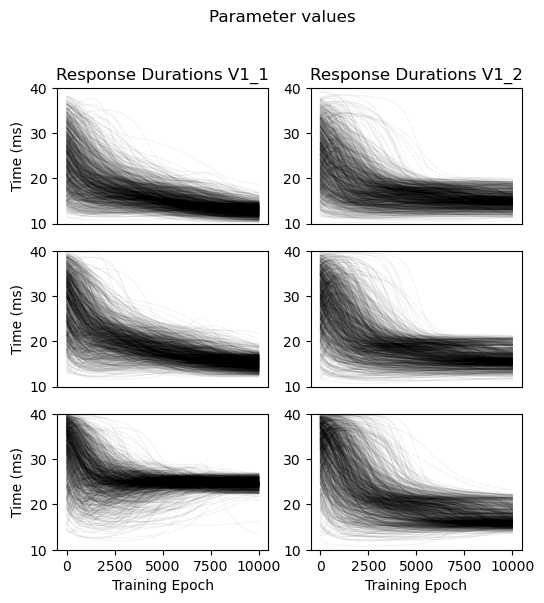

In [29]:
fig, ax = plt.subplots(3,2, figsize = (6,6))
norm = plt.Normalize(0, 1)

param = 4

for col in range(2):
    for row in range(3):
        data = param_history['dLGN_params'][:,:,col,row,param,0,0].T
        ax[row,col].plot(
        param_history['dLGN_params'][:,:,col,row,param,0,0].T,
            linewidth=0.75,
            alpha=0.05,
            color='black'
        )

for i in range(2):
    ax[0,i].set_title(f"Response Durations V1_{i+1}")
for i in range(3):
    ax[i,0].set_ylabel("Time (ms)")
for row in range(2):
    for col in range(2):
        ax[row,col].set_xticks([])
for row in range(3):
    for col in range(2):
        ax[row,col].set_ylim(10,40)
for i in range(2):
    ax[2,i].set_xlabel("Training Epoch")
    # ax[2,i].set_xticks(np.arange(0,5500,500))
    # ax[2,i].set_xticklabels(np.arange(0,5500,500), rotation = 90)
plt.suptitle("Parameter values", y = 1.01)
plt.show()

In [30]:
res = param_history['dLGN_params'].squeeze()
print(res.shape[2:])
n_samples, n_epochs = res.shape[:2]
n_params = np.prod(res.shape[2:])# + np.prod(r2.shape[2:])

res = res.reshape(res.shape[0] * res.shape[1], np.prod(res.shape[2:]))

(2, 3, 5)


In [31]:
pca = PCA() # all epochs included
res_transformed_pca = pca.fit_transform(res).reshape(n_samples, n_epochs, n_params)

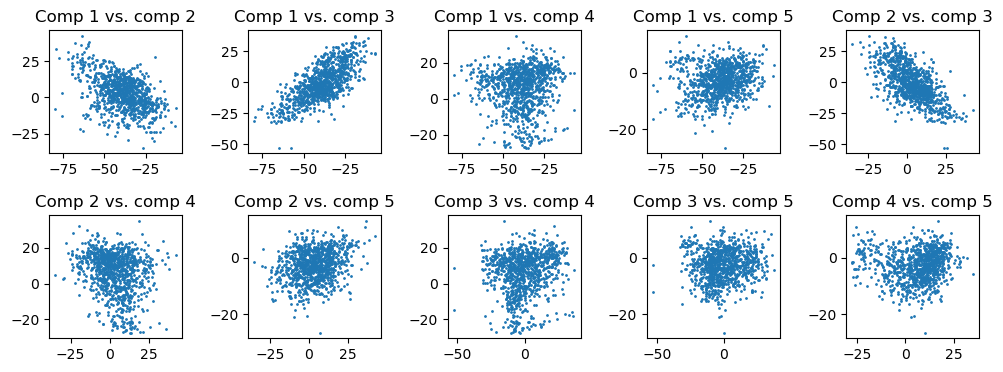

In [32]:
fig, ax = plt.subplots(2,5, figsize = (12,4))

comp_pairs = (list(combinations(np.arange(5), 2)))
i = 0
for row in range(2):
    for col in range(5):
        c0, c1 = comp_pairs[i]
        ax[row, col].scatter(res_transformed_pca[:,-1,c0], res_transformed_pca[:,-1,c1], s = 1) # last epoch
        ax[row, col].set_title(f"Comp {c0+1} vs. comp {c1+1}")
        # ax[row, col].plot(
        #     np.linspace(-100,100,500),
        #     [10]*500, '--', color = 'black'
        # )
        i+=1

fig.subplots_adjust(hspace = 0.5, wspace = 0.5)

In [33]:
lgn_params = [
    'Frequency-time slope',
    'Onset time',
    'Amplitude-time slope',
    'Amplitude',
    'Response duration'
]

v1_params = [
    'Inhibition delay',
    'Inhibition weight'
]

lgn_units = [
    'dLGN_1 into V1_1',
    'dLGN_2 into V1_1',
    'dLGN_3 into V1_1',
    'dLGN_1 into V1_2',
    'dLGN_2 into V1_2',
    'dLGN_3 into V1_2',
]

v1_units = [
    'V1_1',
    'V1_2'
]

full_lgn_params = []
for unit in lgn_units:
    for param in lgn_params:
        full_lgn_params.append(f"{param} ({unit})")

full_v1_params = []
for unit in v1_units:
    for param in v1_params:
        full_v1_params.append(f"{param} ({unit})")
        
param_names = full_lgn_params+full_v1_params

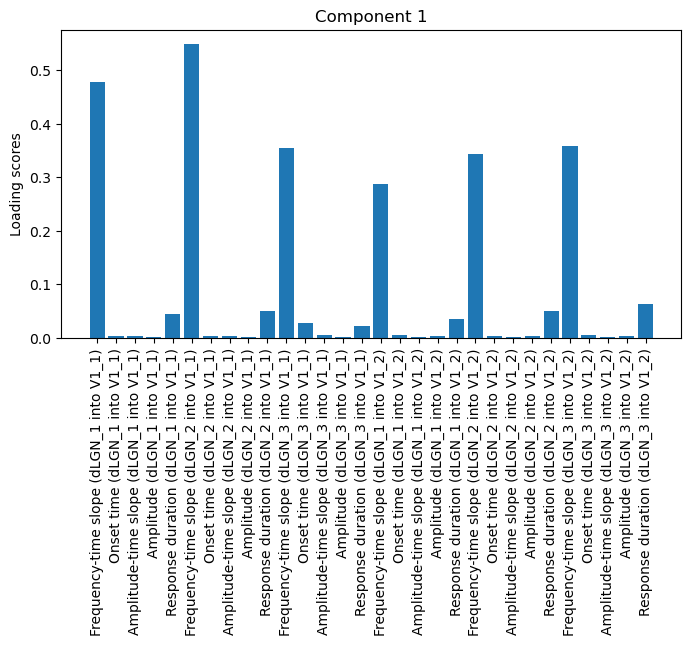

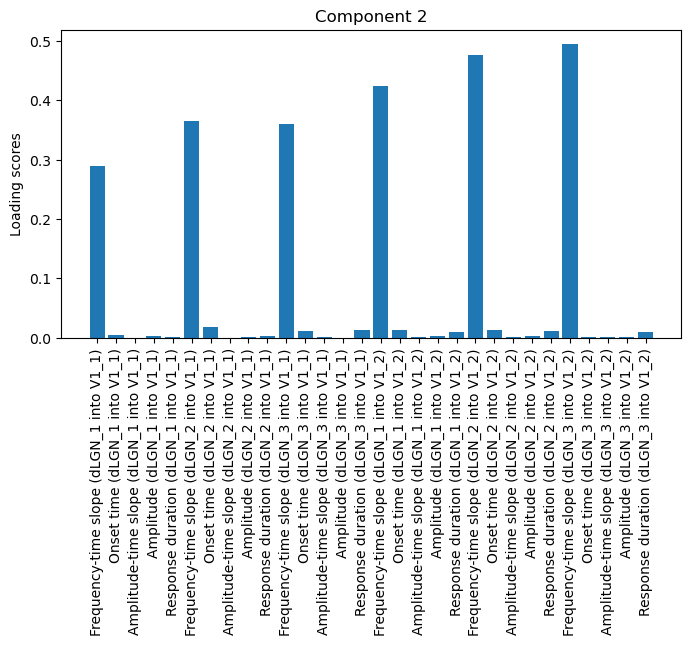

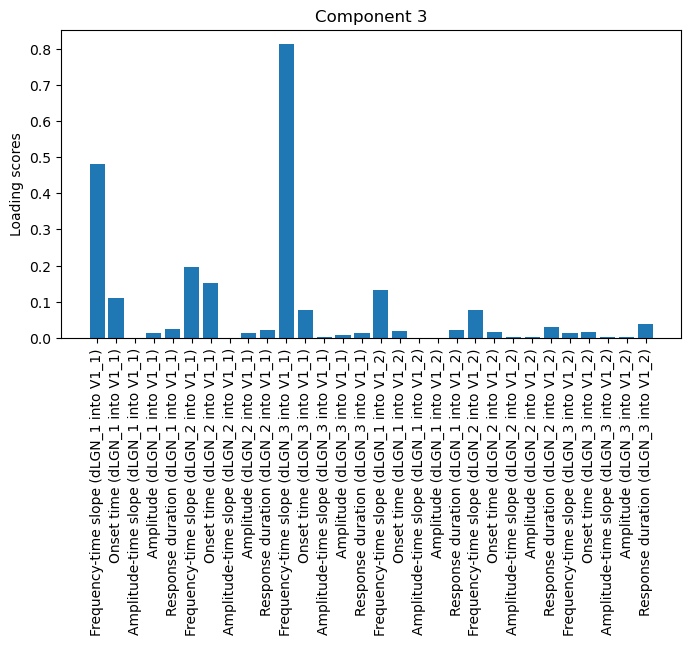

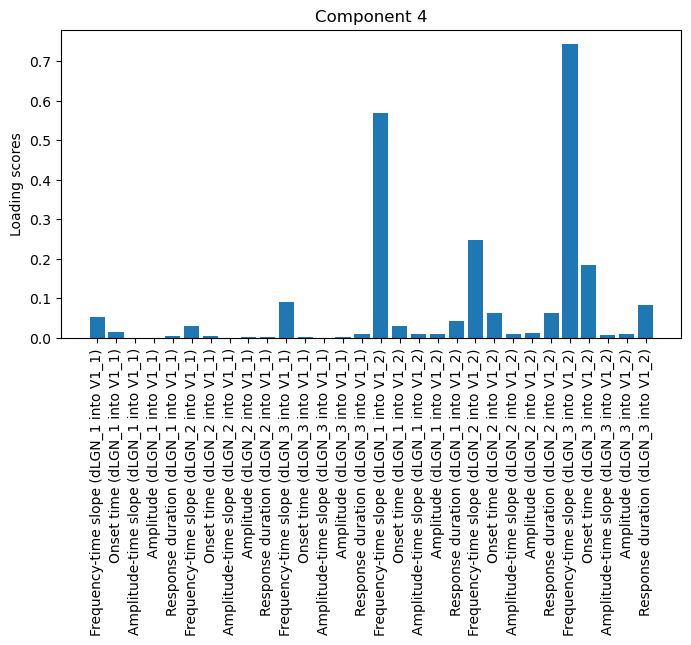

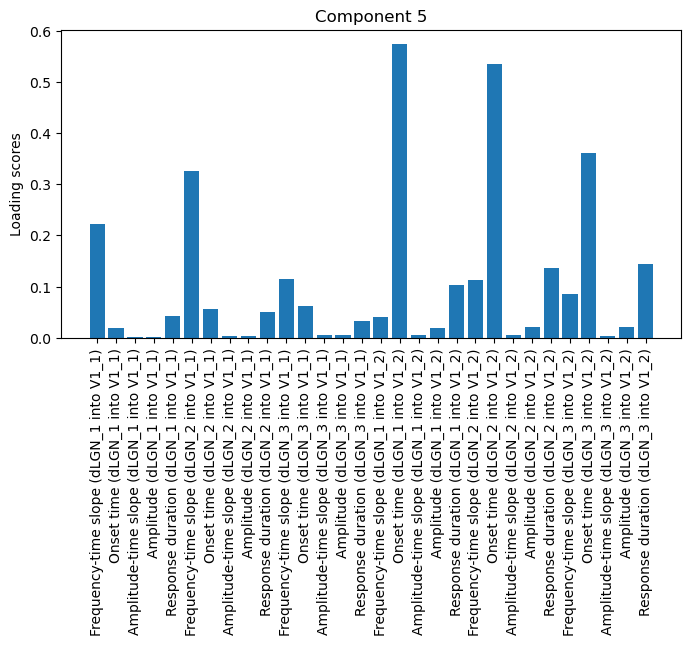

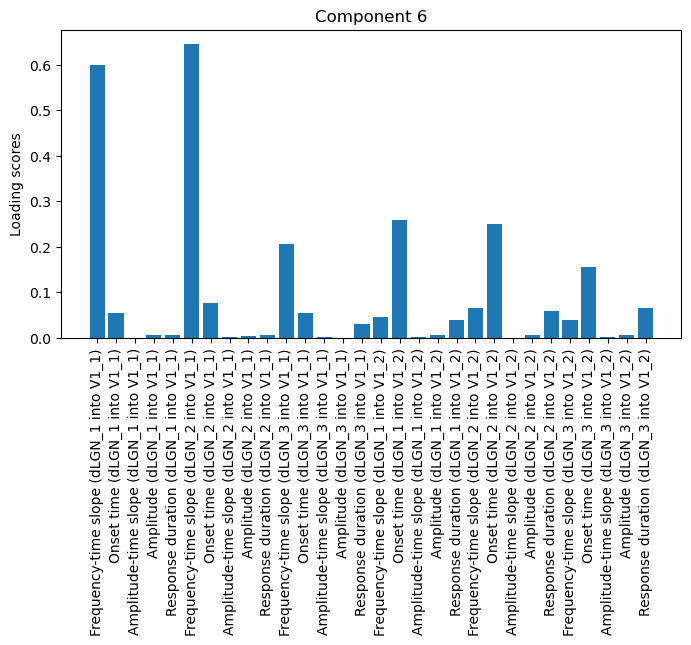

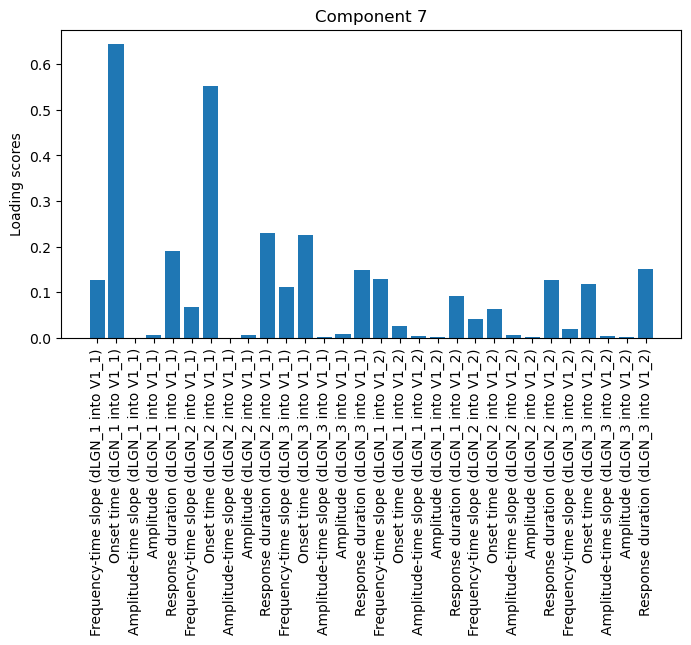

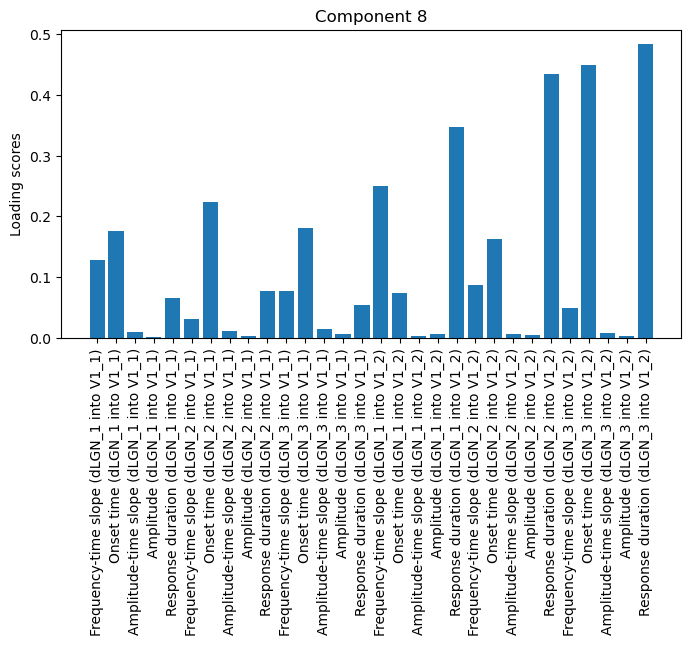

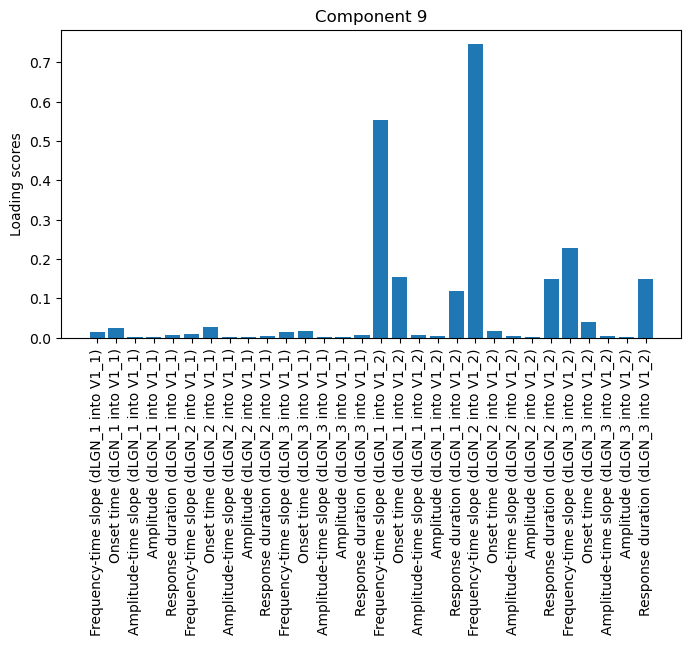

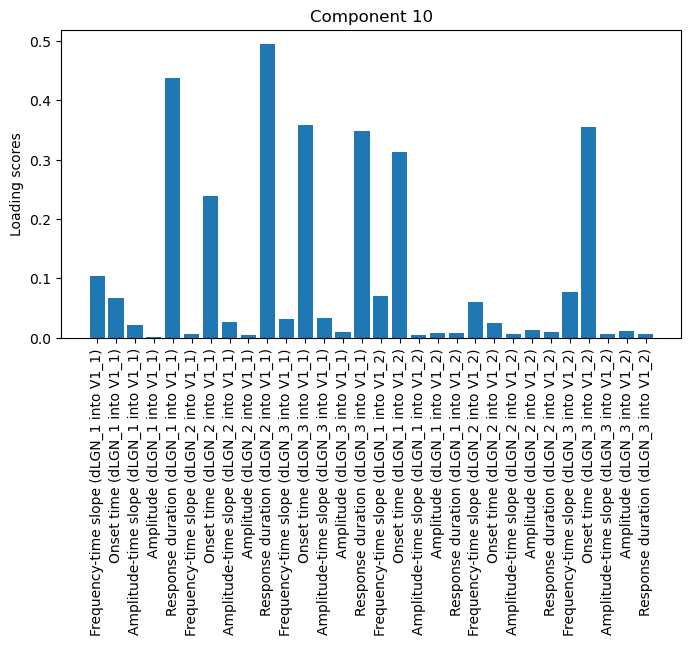

In [34]:
for i in range(10):
    fig, ax = plt.subplots(figsize = (8, 4))
    ax.bar(np.arange(30), np.abs(pca.components_[i]))
    ax.set_xticks(np.arange(30))
    ax.set_xticklabels(param_names[:30], rotation = 90)
    ax.set_ylabel("Loading scores")
    ax.set_title(f"Component {i+1}")